In [1]:
# This notebook measures the APY for pools on different chains: Ethereum, Arbitrum, and Polygon.



import json
import os
import time
import matplotlib.pyplot as plt
from web3 import Web3, HTTPProvider
from datetime import datetime, timedelta
import json


In [2]:
# Pool pre-filtering: duplicate, volume, apy
chains = ['ethereum', 'polygon', 'arbitrum']
chain_pool_dict = {c:{} for c in chains}
with open('curve_requests/banned_pools.json') as f:
    banned_pools = json.load(f)

for chain in chains:
    with open('curve_requests/' + chain + '/' + chain + '.json') as f:
        chain_main_data = json.load(f)

    pool_list = chain_main_data['data']["poolList"]
    ignored = {"dup": 0, "vol": 0, "apy": 0, "ban": 0}
    for pool in pool_list:
        if pool['address'] in chain_pool_dict[chain]:
            print(f"Duplicate pool: {pool['address']}")
            ignored['dup'] += 1
            continue
        
        if float(pool['volumeUSD']) < 1e3:
            # print(f"Volume < 10k: {pool['address']}")
            ignored['vol'] += 1
            continue

        if float(pool['latestWeeklyApy']) < 0.5:
            # print(f"APY < 1%: {pool['address']}")
            ignored['apy'] += 1
            continue

        if pool['address'] in banned_pools:
            # print(f"Banned pool: {pool['address']}")
            ignored['ban'] += 1
            continue
        
        chain_pool_dict[chain][pool['address']] = pool
        # print(f"{chain} {pool['address']} {pool['latestWeeklyApy']} {pool['volumeUSD']}")

    print(f"Pools ({chain}): {len(chain_pool_dict[chain])}, ignored: {ignored}")

Pools (ethereum): 40, ignored: {'dup': 0, 'vol': 669, 'apy': 80, 'ban': 6}
Pools (polygon): 3, ignored: {'dup': 0, 'vol': 727, 'apy': 11, 'ban': 0}
Pools (arbitrum): 2, ignored: {'dup': 0, 'vol': 136, 'apy': 7, 'ban': 0}


In [3]:
# Setup providers and pools

# Ethereum
infura_url_eth = os.getenv('NODE_URL_ETH')
w3_eth = Web3(HTTPProvider(infura_url_eth))
pool_data_eth = []
pool_files_eth = ['main', 'crypto', 'factory', 'factory-crypto', 'factory-crvusd', 'factory-tricrypto']
for file in pool_files_eth:
    with open('curve_requests/ethereum/' + file + '.json') as f:
        pool_data_eth += json.load(f)["data"]["poolData"]
print(f"Ethereum: read {len(pool_data_eth)} pools")
# Index pool data
pool_store_eth = {}
for pool in pool_data_eth:
    if pool['address'] in pool_store_eth:
        print(f"Duplicate eth pool address {pool['address']}")
        continue

    if pool['address'] not in chain_pool_dict['ethereum']:
        # print(f"Pool not in main list: {pool['address']}")
        continue

    pool_store_eth[pool['address']] = pool

# Arbitrum
infura_url_arb = os.getenv('NODE_URL_ARBITRUM')
w3_arb = Web3(HTTPProvider(infura_url_arb))
pool_data_arb = []
pool_files_arb = ['main', 'crypto', 'factory', 'factory-tricrypto']
for file in pool_files_arb:
    with open('curve_requests/arbitrum/' + file + '.json') as f:
        pool_data_arb += json.load(f)["data"]["poolData"]
print(f"Arbitrum: read {len(pool_data_arb)} pools")
# Index pool data
pool_store_arb = {}
for pool in pool_data_arb:
    if pool['address'] in pool_store_arb:
        print(f"Duplicate arb pool address {pool['address']}")

    if pool['address'] not in chain_pool_dict['arbitrum']:
        # print(f"Pool not in main list: {pool['address']}")
        continue

    pool_store_arb[pool['address']] = pool


# Polygon
infura_url_matic = os.getenv('NODE_URL_MATIC')
w3_matic = Web3(HTTPProvider(infura_url_matic))
pool_data_matic = []
pool_files_matic = ['main', 'crypto', 'factory', 'factory-crypto']
for file in pool_files_matic:
    with open('curve_requests/polygon/' + file + '.json') as f:
        pool_data_matic += json.load(f)["data"]["poolData"]
print(f"Polygon: read {len(pool_data_matic)} pools")
# Index pool data
pool_store_matic = {}
for pool in pool_data_matic:
    if pool['address'] in pool_store_matic:
        print(f"Duplicate matic pool address {pool['address']}")

    if pool['address'] not in chain_pool_dict['polygon']:
        # print(f"Pool not in main list: {pool['address']}")
        continue
    pool_store_matic[pool['address']] = pool

print(f"Ethereum final pools: {len(pool_store_eth)}")
print(f"Arbitrum final pools: {len(pool_store_arb)}")
print(f"Polygon final pools: {len(pool_store_matic)}")
print(f"Total pools: {len(pool_store_eth) + len(pool_store_arb) + len(pool_store_matic)}")


# Fix the latest block by anchoring it to a multiple of some number (2 weeks period on each chain)
days_modulo = 14
chain_periods = {
    1: 12, # eth
    137: 2.2, # matic
    42161: 0.26 # arb
}
current_block_eth = (w3_eth.eth.block_number // int(days_modulo*24*3600/chain_periods[1])) * int(days_modulo*24*3600/chain_periods[1])
print(f"Current block (eth): {current_block_eth}")
current_block_matic = (w3_matic.eth.block_number // int(days_modulo*24*3600/chain_periods[137])) * int(days_modulo*24*3600/chain_periods[137])
print(f"Current block (matic): {current_block_matic}")
current_block_arb = (w3_arb.eth.block_number // int(days_modulo*24*3600/chain_periods[42161])) * int(days_modulo*24*3600/chain_periods[42161])
print(f"Current block (arb): {current_block_arb}")


Ethereum: read 800 pools
Duplicate eth pool address 0xEd279fDD11cA84bEef15AF5D39BB4d4bEE23F0cA
Arbitrum: read 148 pools
Duplicate arb pool address 0x30dF229cefa463e991e29D42DB0bae2e122B2AC7
Polygon: read 732 pools
Ethereum final pools: 40
Arbitrum final pools: 2
Polygon final pools: 3
Total pools: 45
Current block (eth): 18345600
Current block (matic): 48933802
Current block (arb): 144221517


In [4]:
# Define function for getting pool APY. Daily sampling.

# Reuse ABI of 3pool (might cause issues, pools have differences)
with open('./curve_pools/abi/3pool.abi.json', 'r') as f:
    contract_abi = json.load(f)

# Cache the results of the get_virtual_price() call
with open('curve_requests/cache_vprice.json') as f:
    cache_db = json.load(f)

def get_pool_apys(chain_id, provider, pool_addr, current_block, days):
    contract = provider.eth.contract(address=pool_addr, abi=contract_abi)
    blocks = [current_block - int(i * 60 * 60 * 24 // chain_periods[chain_id]) for i in range(days)]
    virtual_prices = []
    for block in blocks:
        # Check cache. Tuple is hashable but cannot be json serialized as a key
        key = str((provider.eth.chain_id, pool_addr, block))
        if key in cache_db:
            virtual_prices.append(cache_db[key])
            continue

        # Query blockchain
        try:
            # print(f"Getting virtual price at block {block}")
            virtual_price = contract.functions.get_virtual_price().call(block_identifier=block)
            virtual_prices.append(virtual_price)
            cache_db[key] = virtual_price
        except Exception as e:
            print(f"Chain: {provider.eth.chain_id} Pool: {pool_addr} Block: {block} Error: {e}")

    # Calculate APY
    apys = []
    for i in range(len(virtual_prices) - 1):
        apy = (virtual_prices[i] / virtual_prices[i + 1]) ** 365 - 1
        apy *= 100
        apys.append(apy)

    return apys


In [5]:
# Get APYs for each pool of each chain

# Backtest period
DAYS = 30

# Ethereum
pool_apy_eth = []
current_timestamp = time.time()
print(f"Current eth block: {current_block_eth}")
for pool in pool_store_eth.values():
    pool_addr = pool['address']
    t_start = time.time()
    apys = get_pool_apys(1, w3_eth, pool_addr, current_block_eth, DAYS)
    t_end = time.time()
    print(f"Time taken for eth pool {pool_addr[:8]}: {t_end - t_start:.3f}s")
    pool_apy_eth.append((pool_addr, apys))

# Arbitrum
pool_apy_arb = []
print(f"Current arb block: {current_block_arb}")
for pool in pool_store_arb.values():
    pool_addr = pool['address']
    t_start = time.time()
    apys = get_pool_apys(42161, w3_arb, pool_addr, current_block_arb, DAYS)
    t_end = time.time()
    print(f"Time taken for arb pool {pool_addr[:8]}: {t_end - t_start:.3f}s")
    pool_apy_arb.append((pool_addr, apys))

# Polygon
pool_apy_matic = []
print(f"Current matic block: {current_block_matic}")
for pool in pool_store_matic.values():
    pool_addr = pool['address']
    t_start = time.time()
    apys = get_pool_apys(137, w3_matic, pool_addr, current_block_matic, DAYS)
    t_end = time.time()
    print(f"Time taken for matic pool {pool_addr[:8]}: {t_end - t_start:.3f}s")
    pool_apy_matic.append((pool_addr, apys))

# Save cache
with open('curve_requests/cache_vprice.json', 'w') as f:
    json.dump(cache_db, f)

Current eth block: 18345600
Time taken for eth pool 0xA96A65: 1.872s
Time taken for eth pool 0xDC2431: 1.622s
Time taken for eth pool 0xA5407e: 1.178s
Time taken for eth pool 0x4f0626: 1.440s
Time taken for eth pool 0xEd279f: 1.235s
Time taken for eth pool 0x618788: 1.252s
Time taken for eth pool 0xBfAb6F: 1.030s
Time taken for eth pool 0xD51a44: 0.847s
Time taken for eth pool 0xB57649: 0.956s
Time taken for eth pool 0x752eBe: 1.482s
Time taken for eth pool 0x9D0464: 1.016s
Time taken for eth pool 0xc270b3: 1.441s
Time taken for eth pool 0x103381: 2.831s
Time taken for eth pool 0x447Ddd: 1.228s
Time taken for eth pool 0x828b15: 2.385s
Time taken for eth pool 0x453D92: 2.847s
Time taken for eth pool 0x413928: 0.933s
Time taken for eth pool 0x892D70: 1.430s
Time taken for eth pool 0x99f5aC: 1.144s
Time taken for eth pool 0x21E27a: 1.020s
Time taken for eth pool 0x59Ab5a: 0.836s
Time taken for eth pool 0x69ACcb: 0.780s
Time taken for eth pool 0x941Eb6: 0.930s
Time taken for eth pool 0xC26

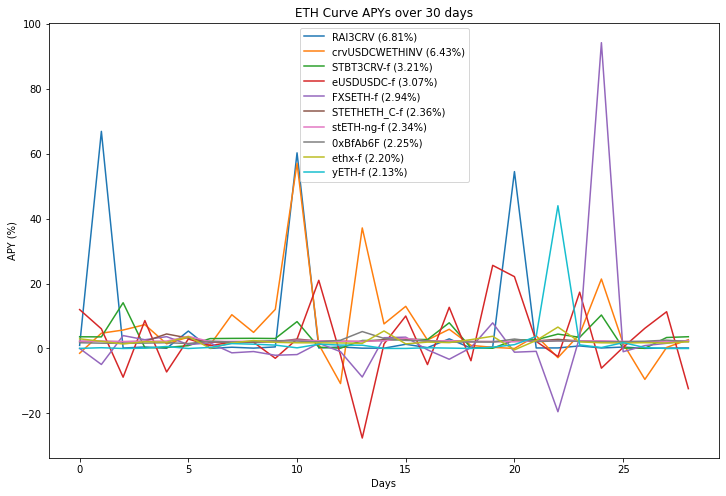

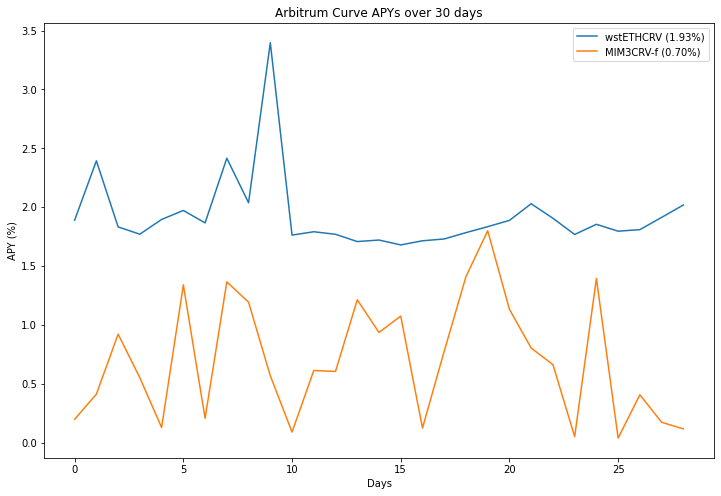

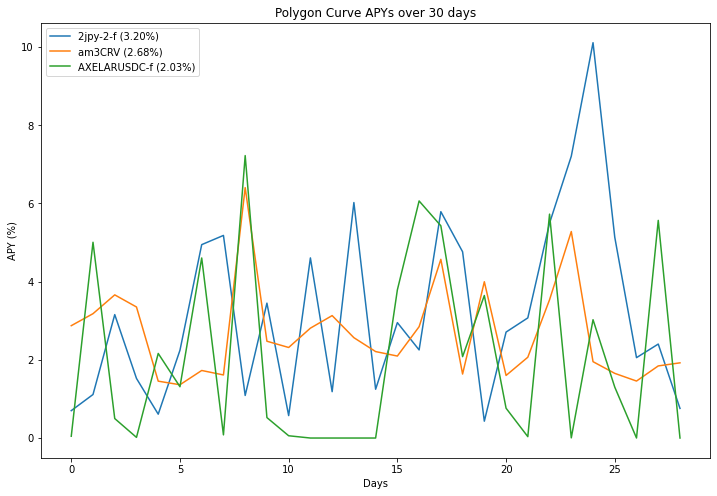

In [6]:
# Plot APYs for each pool, group by chains

# Ethereum
apy_top_eth = 10
pool_apy_top_eth = sorted(pool_apy_eth, key=lambda x: sum(x[1]) / len(x[1]), reverse=True)[:apy_top_eth]
plt.figure(figsize=(12, 8))
for pool_addr,apys in pool_apy_top_eth:
    # Pool label
    sym = ""
    if "symbol" in pool_store_eth[pool_addr]:
        sym = pool_store_eth[pool_addr]["symbol"]
    else:
        sym = pool_addr[:8]

    # Compute avg APY
    avg_apy = sum(apys) / len(apys)

    # print(f"avg APY: {avg_apy:.2f}% for {sym}")
    plt.plot(range(DAYS - 1), apys, label=f"{sym} ({avg_apy:.2f}%)")

plt.legend()
plt.title(f"ETH Curve APYs over {DAYS} days")
plt.xlabel("Days")
plt.ylabel("APY (%)")
plt.show()

# Arbitrum
apy_top_arb = 10
pool_apy_top_arb = sorted(pool_apy_arb, key=lambda x: sum(x[1]) / len(x[1]), reverse=True)[:apy_top_arb]
plt.figure(figsize=(12, 8))
for pool_addr,apys in pool_apy_top_arb:
    # Pool label
    sym = ""
    if "symbol" in pool_store_arb[pool_addr]:
        sym = pool_store_arb[pool_addr]["symbol"]
    else:
        sym = pool_addr[:8]

    # Compute avg APY
    avg_apy = sum(apys) / len(apys)

    # print(f"avg APY: {avg_apy:.2f}% for {sym}")
    plt.plot(range(DAYS - 1), apys, label=f"{sym} ({avg_apy:.2f}%)")

plt.legend()
plt.title(f"Arbitrum Curve APYs over {DAYS} days")
plt.xlabel("Days")
plt.ylabel("APY (%)")
plt.show()

# Polygon
apy_top_matic = 10
pool_apy_top_matic = sorted(pool_apy_matic, key=lambda x: sum(x[1]) / len(x[1]), reverse=True)[:apy_top_matic]
plt.figure(figsize=(12, 8))
for pool_addr,apys in pool_apy_top_matic:
    # Pool label
    sym = ""
    if "symbol" in pool_store_matic[pool_addr]:
        sym = pool_store_matic[pool_addr]["symbol"]
    else:
        sym = pool_addr[:8]

    # Compute avg APY
    avg_apy = sum(apys) / len(apys)

    # print(f"avg APY: {avg_apy:.2f}% for {sym}")
    plt.plot(range(DAYS - 1), apys, label=f"{sym} ({avg_apy:.2f}%)")

plt.legend()
plt.title(f"Polygon Curve APYs over {DAYS} days")
plt.xlabel("Days")
plt.ylabel("APY (%)")
plt.show()
